In [ ]:
'''
#mean reversion and momentum properties are exhibited by a single time series.
#a long term memory drives the long term trend- that is there is high levels of autocorrelation in asset values (momentum)
    -we use Exponential moving average
#we can use detrended fluctuation analysis to strip out the temporal fluctuations, which follow a mean reversion process.

### We stack multiple lookback periods of EMA indicators (short, med, fast) to see if this improves sharpe and position sizing


#Risk management- what happens if we simply set some rules around peaks of asset price (52week) 
    or some momentum indicator (20,2) to stop us jumping in
'''

In [1]:
#test for dollar bars later
import xbbg
import scipy
from scipy.interpolate import CubicSpline
from xbbg import blp
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt
import os
import matplotlib.ticker as plticker
import pandas_datareader as pdr
import datetime
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
tickers = ['SFRZ4 Comdty']


#last 10 business days of intraday data
df = pd.DataFrame()

for ticker in tickers:
    for i in range(0,2*252):
        #print(i)
        today = datetime.datetime.today()
        date = today - BDay(i)
        #print(date)


        #lets do outright futures, swap spreads and future spreads
        fut = blp.bdib(ticker=ticker, dt= date , ref='CME', interval=1)
        if fut.columns.nlevels > 1:
            fut.columns = fut.columns.droplevel(0)
        df = df.append(fut)

    df['ticker']= ticker
    df['date']=df.index.strftime("%m/%d/%Y")
    df['time']= df.index.strftime("%H:%M:%S")
    df.sort_index(ascending=True, inplace = True)
    df.index = df.index.tz_localize(None)

    
trades = df[['close','volume']].copy()
trades.reset_index(inplace= True)
trades['index']=pd.to_numeric(trades['index'])#trades['index'].astype(str)

def calculateMaxDD(cumret):
# =============================================================================
# calculation of maximum drawdown and maximum drawdown duration based on
# cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
# i is the index of the day with maxDD.
# =============================================================================
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
             
    maxDD, i=np.min(drawdown), np.argmin(drawdown) # drawdown < 0 always
    maxDDD=np.max(drawdownduration)
    return maxDD, maxDDD, i
#exponential weighted moving average signal
def rolling_z_score(df, lookback_mu, lookback_sigma):
    mu = df.ewm(lookback_mu).mean()
    sigma = df.ewm(lookback_sigma).std()
    df['indicator'] = (df.copy() - mu) / sigma
    return df


def signal_rolling_z_meanreversion(df,lookback_mu, lookback_sigma, bound):
    
    signals=pd.DataFrame(rolling_z_score(df,lookback_mu, lookback_sigma))
    signals['positions']=0

    #increase position size relative to strength of indicator pass the 
    signals.loc[signals["indicator"] <= -bound , "positions"] = -signals["indicator"]-bound
    signals.loc[signals["indicator"] >= bound , "positions"] = -signals["indicator"]+bound
    #sizing determined by tanh function to set between -1 and 1, this stops us from overbetting/ setting bets with concurrent signals >1
    #signals["signals"]=np.tanh(signals["positions"])

    return signals
signal_df = signal_rolling_z_meanreversion(volume_trades[['close']], 600,600,2)
#generate volume bars we only fill a new bar if a set number of futures are traded. 
#This will remove a lot of the asia session futures with low liquitiy
def generate_volumebars(trades, frequency=10):
    times = trades[:,0]
    prices = trades[:,1]
    volumes = trades[:,2]
    ans = np.zeros(shape=(len(prices), 6))
    candle_counter = 0
    vol = 0
    lasti = 0
    for i in range(len(prices)):
        vol += volumes[i]
        if vol >= frequency:
            #print(times[i] )
            #print(ans[candle_counter][0])
            ans[candle_counter][0] = times[i]             # time
            ans[candle_counter][1] = prices[lasti]                     # open
            ans[candle_counter][2] = np.max(prices[lasti:i+1])         # high
            ans[candle_counter][3] = np.min(prices[lasti:i+1])         # low
            ans[candle_counter][4] = prices[i]                         # close
            ans[candle_counter][5] = np.sum(volumes[lasti:i+1])        # volume
            candle_counter += 1
            lasti = i+1
            vol = 0
    return ans[:candle_counter]

#determine trading volume threshold
#lets just use average for now.
#going fwd we can do a 20 day moving average sampled about 50 times a day
threshold = round(trades['volume'].mean(),0)

volume_trades =generate_volumebars(trades.to_numpy(), frequency =threshold)

volume_trades = pd.DataFrame(volume_trades, columns =['index','open','high','low','close','volume'])
volume_trades.set_index('index', inplace = True)

trades.set_index('index', inplace = True)
#convert back to datetime
volume_trades.index = pd.to_datetime(volume_trades.index.astype(np.int64), format ='%Y-%m-%d %H:%M:%S')
trades.index = pd.to_datetime(trades.index, format ='%Y-%m-%d %H:%M:%S')


C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fut)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2605112692.py:40: FutureWarning: The frame.appen

In [196]:
#Mean reversion detrend strategy
# we want different lookback periods
# different lag periods on the detrended time series
#holding period, average time to cross mid point, we can optimize later.

#analytics - # crosses through mid, max and # drawdown, convexity & kurtosis.
#for later... stop loss maybe using some form of 


#For any futures product 
import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
trade_long_list = []
trade_short_list =[]

#results lists
results_lookback_list = []
results_hold_list = []
results_bound_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []
bound_entry_list =[]
lookback_list = []
holdtime_list = []
long_time_list = []
short_time_list = []
long_avg_return_list = []
short_avg_return_list = []
mean_return_list = []
hitrate_list =[]
long_hitrate_list = []
short_hitrate_list = []

winners_avg_return_list = []
losers_avg_returns_list = []
hitrate_bro_list =[]
mean_return_bro_list =[]
sharpe_bro_list =[]
apr_bro_list = []

#brokerage
#assume 0.5bp slippage
brokerage = 0.005
#average ticks per day
daily_tick_count_df = daily_tick_count_df[(daily_tick_count_df.index.date>min(daily_tick_count_df.index.date))&(daily_tick_count_df.index.date<max(daily_tick_count_df.index.date))]
average_daily_ticks = round(daily_tick_count_df.groupby([daily_tick_count_df.index.date]).count().mean(),0)

signal_settings =[(27660,120,1.5,'slow'),(3600,360,1.9,'medium'),(1500,540,1.5,'fast')]


#master position dataframe
df_master_positions =pd.DataFrame(index = volume_trades.index)
df_master_long =pd.DataFrame(index = volume_trades.index)
df_master_short =pd.DataFrame(index = volume_trades.index)

for j in signal_settings:
    lookback = j[0]
    holdtime = j[1]
    bound = j[2]
    speed = j[3]
    
    start_time = time.time()
    print('lookback '+str(lookback))
    #set all active positions to = 0 between 7am and 5pm our trading period
    df=df.between_time('7:00', '17:00')     
    #generate the mean reversion zscore signal
    df = signal_rolling_z_meanreversion(volume_trades[['close']], lookback,lookback,bound)    ##Apply lags
    #***Incomplete****set conditions where we only initiate positions during our time zone est 7am - (5pm- holdtime)
    #create table of longs and shorts
    longs= df['positions']>0
    shorts= df['positions'] <0
    pos=np.zeros(df[['close']].shape)
    pos_long = np.zeros(df[['close']].shape)
    pos_short = np.zeros(df[['close']].shape)
    for h in range(holdtime-1):
        # signal can double down but we modify for this later. This is good data for strength of the signal
        #print("holdtime_loop_"+str(h))
        long_lag=longs.copy().shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 
        #print("long_lag")
        #print(long_lag.tail(50))
        short_lag=shorts.copy().shift(h).fillna(False)
        ##set condition to take profit once we hit the mean on an open position.
        #- this involves zeroing out pos where [-1,-1] indicator returns to 0 
        #print(df['zp_data_standard'][long_lag])
        #if df['zp_data_standard'][]   
        pos[long_lag]=pos[long_lag]+1
        pos[short_lag]=pos[short_lag]-1       
        pos_long[long_lag] = pos_long[long_lag]+1
        pos_short[short_lag] = pos_short[short_lag]-1       



    pos=pd.DataFrame(pos, index = longs.index)
    pos_long = pd.DataFrame(pos_long, index = longs.index)
    pos_long['entry_pos'] = longs
    pos_long['entry_pos'] = pos_long['entry_pos'].apply(lambda x: 1 if x == True else 0)
    pos_short = pd.DataFrame(pos_short, index = longs.index)
    pos_short['entry_pos'] = shorts
    pos_short['entry_pos'] = pos_short['entry_pos'].apply(lambda x: -1 if x == True else 0)
    pos[pos[0]>1] = 1
    pos[pos[0]<-1] = -1
          
    #where entries need to be between 7am and 5pm


    pos_long['exit'] = df['indicator'].apply(lambda x: -1 if x > 0 else 0)
    pos_long[0] = pos_long[0].apply(lambda x: 1 if x >0 else 0)
    pos_long[0][pos_long[0]>0]=1


    #shorts close out where the signal turns negative 
    pos_short['exit'] = df['indicator'].apply(lambda x: 1 if x < 0 else 0)
    pos_short[0] = pos_short[0].apply(lambda x: -1 if x <0 else 0)
    pos_short[0][pos_short[0]<0]=-1
    #target hit/reversion back to the mean- we create a new position column to close out before the holdtime is met
    #longs
    pos_with_tp_list = [0]
    pos_long_reset_idx = pos_long.reset_index()
    #pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
    #                         if (row[0]==1 & (pos_with_tp_list[row.name-1] == -1 | row['exit'] == -1)) 
    #                         else pos_with_tp_list.extend([0]), axis = 1 )
    pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
                             if ((row[0]==1) & ((row["exit"]==-1 )|(pos_with_tp_list[row.name-1] == -1)))
                             else pos_with_tp_list.extend([0]), axis = 1 )

    #pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
    #                         if (row[0]==1 &(row["exit"]==-1))
    #                         else pos_with_tp_list.extend([0]), axis = 1 )
    del pos_with_tp_list[0]
    #pos_long_test = pos_long.copy()
    pos_long['pos_with_tp']=pos_with_tp_list
    pos_long['pos_with_tp']=pos_long['pos_with_tp'].copy() +pos_long[0]

    #shorts
    pos_with_tp_list = [0]
    pos_short_reset_idx = pos_short.reset_index()
    #pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
    #                         if (row[0]==1 & (pos_with_tp_list[row.name-1] == -1 | row['exit'] == -1)) 
    #                         else pos_with_tp_list.extend([0]), axis = 1 )
    pos_short_reset_idx.apply(lambda row: pos_with_tp_list.extend([1]) 
                             if ((row[0]==-1) & ((row["exit"]==1 )|(pos_with_tp_list[row.name-1] == 1)))
                             else pos_with_tp_list.extend([0]), axis = 1 )

    #pos_long_reset_idx.apply(lambda row: pos_with_tp_list.extend([-1]) 
    #                         if (row[0]==1 &(row["exit"]==-1))
    #                         else pos_with_tp_list.extend([0]), axis = 1 )
    del pos_with_tp_list[0]
    #pos_short_test = pos_short.copy()
    pos_short['pos_with_tp']=pos_with_tp_list
    pos_short['pos_with_tp']=pos_short['pos_with_tp'].copy() +pos_short[0]
    pos_original = pos[0].copy()
    pos[0]=(pos_long[['pos_with_tp']]+pos_short[['pos_with_tp']])
    df_master_positions[str(speed)] = pos[0]
    df_master_long[str(speed)] = pos_long['pos_with_tp']
    df_master_short[str(speed)] = pos_short['pos_with_tp']
#combine the speeds

df_master_long["pos_with_tp"] = df_master_long['slow']+df_master_long['medium']+df_master_long['fast']
df_master_short["pos_with_tp"] = df_master_short['slow']+df_master_short['medium']+df_master_short['fast']

df_master_positions[0] = df_master_positions['slow']+df_master_positions['medium']+df_master_positions['fast']
pos[0] = df_master_positions[0].copy()
scaler = MaxAbsScaler()
standard = scaler.fit_transform(pos[[0]])
pos[0]= standard
pos[0] = np.tanh(pos[0])
#scale positions by log returns
#find start of trades
#pos1 =df_master_positions[0].copy()
#pos1['trade_grouping'] = pos1[0].diff().ne(0).cumsum()
#pos1['trade_grouping_diff'] =pos1['trade_grouping'].diff(1)
#pos1['trade_grouping_diff'] = pos1['trade_grouping_diff']
#pos1['trade_grouping_diff'] = pos1['trade_grouping_diff']*pos1[0]
#pos1 = pd.merge(df, pos1[[0,'trade_grouping_diff']].dropna(), how = 'left', left_index = True, right_index = True)
#pos1['vol'] = pos1['close'].diff().ewm(com = lookback).std()
#pos1['vol_start_pos'] = abs(pos1['trade_grouping_diff'])*pos1['vol'] 
#pos1['vol_start_pos'] = pos1['vol_start_pos'].replace(to_replace=0, method='ffill')
#pos1['pos_volscaled'] = pos1[0]/pos1['vol_start_pos']

#scaler = MaxAbsScaler()
#standard = scaler.fit_transform(pos1[['pos_volscaled']])
#pos1['pos_volscaled']= standard

#performance analytics
#count long and short trades
pos_long['trade_grouping']=pos_long['pos_with_tp'].diff().ne(0).cumsum()
number_longs= len(pos_long['trade_grouping'][pos_long['pos_with_tp']!=0].unique())
pos_short['trade_grouping']=pos_short['pos_with_tp'].diff().ne(0).cumsum()
number_shorts=len(pos_short['trade_grouping'][pos_short['pos_with_tp']!=0].unique())

#average ticks/time per trade
longs_avg_ticks = round(pos_long[['trade_grouping','pos_with_tp']][pos_long['pos_with_tp']!=0].groupby('trade_grouping').sum().mean()[0],0)
shorts_avg_ticks = round(pos_short[['trade_grouping','pos_with_tp']][pos_short['pos_with_tp']!=0].groupby('trade_grouping').sum().mean()[0],0)
long_time_list.extend([longs_avg_ticks])
short_time_list.extend([shorts_avg_ticks])

#return per trade (absolute bps)
#longs and shorts

long_pnl_df = pd.merge(pos_long.shift(),df[["close"]].diff(), how = 'left', left_index = True, right_index = True)
long_pnl_df['abs_return'] = long_pnl_df['pos_with_tp']*long_pnl_df['close']
short_pnl_df = pd.merge(pos_short.shift(),df[["close"]].diff(), how = 'left', left_index = True, right_index = True)
short_pnl_df['abs_return'] = short_pnl_df['pos_with_tp']*short_pnl_df['close']

avg_long_pnl = long_pnl_df[['trade_grouping','abs_return']][long_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum().mean()
avg_short_pnl = short_pnl_df[['trade_grouping','abs_return']][short_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum().mean()
avg_pnl_df= (long_pnl_df[['trade_grouping','abs_return']][long_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()
             .append(short_pnl_df[['trade_grouping','abs_return']][short_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()))
avg_pnl_bro_df = avg_pnl_df - brokerage
long_avg_return_list.extend([avg_long_pnl][0])
short_avg_return_list.extend([avg_short_pnl][0])
mean_return_list.extend([avg_pnl_df.mean()[0]])
hitrate_list.extend([len(avg_pnl_df[avg_pnl_df['abs_return']>0])/len(avg_pnl_df)])

long_hitrate_df = long_pnl_df[['trade_grouping','abs_return']][long_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()
short_hitrate_df = short_pnl_df[['trade_grouping','abs_return']][short_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()

long_hitrate_list.extend([len(long_hitrate_df[long_hitrate_df['abs_return']>0])/len(long_hitrate_df)])
short_hitrate_list.extend([len(short_hitrate_df[short_hitrate_df['abs_return']>0])/len(short_hitrate_df)])

#after brokerage stats
hitrate_bro_list.extend([len(avg_pnl_bro_df[avg_pnl_bro_df['abs_return']>0])/len(avg_pnl_bro_df)])
mean_return_bro_list.extend([avg_pnl_bro_df.mean()[0]])


#PNL and sharpe vol shifted 
pnl=np.sum((pos.shift().values)*(df[["close"]].pct_change()), axis=1) # daily P&L of the strategy
pnl_long =np.sum((pos_long[[0]].shift().values)*(df[["close"]].pct_change()), axis=1)
pnl_short = np.sum((pos_short[[0]].shift().values)*(df[["close"]].pct_change()), axis=1)
ret=pnl#/np.sum(np.abs(pos.shift()), axis=1)
#print(np.mean(ret))
#print(np.std(ret))
cumret=(np.cumprod(1+ret)-1)
cumret_long=(np.cumprod(1+pnl_long)-1)
cumret_short=(np.cumprod(1+pnl_short)-1)
#print("---returns data %s seconds ---" % (time.time() - start_time))
#start_time = time.time()
sharpe = np.sqrt(252*average_daily_ticks)*np.mean(ret)/np.std(ret)
#print("---sharpe data %s seconds ---" % (time.time() - start_time))
#start_time = time.time()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**((252*average_daily_ticks)/len(ret))-1, np.sqrt(252*average_daily_ticks)*np.mean(ret)/np.std(ret)))

maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
#print("---maxdd data %s seconds ---" % (time.time() - start_time))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
results_lookback_list.append(lookback)
results_hold_list.append(holdtime)
results_bound_trigger_list.append(bound)
apr_list.append(np.prod(1+ret)**((252*average_daily_ticks)/len(ret))-1)
sharpe_list.append(sharpe)
dd_list.append(maxDD)
dd_time_list.append(maxDDD)
trade_long_list.append(number_longs)
trade_short_list.append(number_shorts)
#print('mean return=%f vs mean return after bro =%f' % (np.mean(ret), np.mean(pnl_sharpe)))
print("---maxdd data %s seconds ---" % (time.time() - start_time))
    
df_results['lookback'] = results_lookback_list
#df_results['indicator_lag'] = np.tile(lag_list, len(df_results) // len(lag_list) + 1)[:len(df_results)]  
df_results['holdtime_mins'] = results_hold_list
df_results['trigger_bound'] = results_bound_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['long_avg_ticks'] = long_time_list
df_results['short_avg_ticks'] = short_time_list
df_results['long_avg_abs_pnl'] = long_avg_return_list
df_results['short_avg_abs_pnl'] = short_avg_return_list
df_results['long_hitrate'] = long_hitrate_list
df_results['short_hitrate'] = short_hitrate_list
df_results['mean_return_bps'] = mean_return_list
df_results['hitrate'] = hitrate_list
df_results['hitrate_after_bro']  = hitrate_bro_list


lookback 27660


C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2714726482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['indicator'] = (df.copy() - mu) / sigma


lookback 3600


C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2714726482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['indicator'] = (df.copy() - mu) / sigma


lookback 1500


C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\2714726482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['indicator'] = (df.copy() - mu) / sigma
C:\Users\chengc3\AppData\Local\Temp\ipykernel_19628\119990534.py:211: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avg_pnl_df= (long_pnl_df[['trade_grouping','abs_return']][long_pnl_df['pos_with_tp']!=0].groupby('trade_grouping').sum()


APR=0.012243 Sharpe=1.431092
Max DD=-0.005077 Max DDD in days=6597
---maxdd data 6.400030851364136 seconds ---


<AxesSubplot:xlabel='index'>

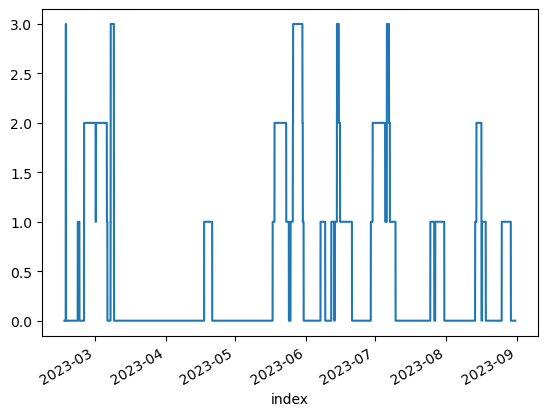

In [192]:
df_master_long[0].plot()

<AxesSubplot:xlabel='index'>

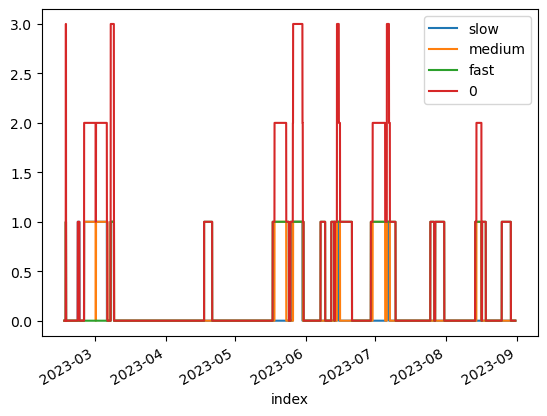

In [193]:
df_master_long.plot()

In [127]:
pos1 =pos.copy()
pos1['trade_grouping'] = pos1[0].diff().ne(0).cumsum()
pos1['trade_grouping_diff'] =pos1['trade_grouping'].diff(1)
#pos1['trade_grouping_diff'] = abs(pos1['trade_grouping_diff'])#*pos1[0] #add spread to start of trade if long and vice versa
pos1 = pd.merge(df, pos1, how = 'left', left_index = True, right_index = True)    
pos1['vol'] = pos1[pos1['trade_grouping_diff']!=0]['close'].diff().ewm(com = lookback).std()

<AxesSubplot:xlabel='index'>

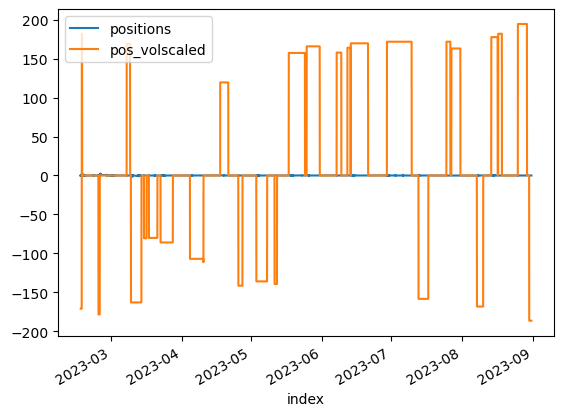

In [165]:
pos1 =pos.copy()
pos1['trade_grouping'] = pos1[0].diff().ne(0).cumsum()
pos1['trade_grouping_diff'] =pos1['trade_grouping'].diff(1)
pos1['trade_grouping_diff'] = pos1['trade_grouping_diff']
pos1['trade_grouping_diff'] = pos1['trade_grouping_diff']*pos1[0]
pos1 = pd.merge(df.dropna(), pos1[[0,'trade_grouping_diff']].dropna(), how = 'left', left_index = True, right_index = True)
pos1['vol'] = pos1['close'].diff().ewm(com = lookback).std()
pos1['vol_start_pos'] = abs(pos1['trade_grouping_diff'])*pos1['vol'] 
pos1['vol_start_pos'] = pos1['vol_start_pos'].replace(to_replace=0, method='ffill')
pos1['pos_volscaled'] = pos1[0]/pos1['vol_start_pos']

#pos1[pos1.isna()==True]
#pos1[['trade_grouping_diff']].iloc[0:1000].plot()
pos1[['positions','pos_volscaled']].plot()

<AxesSubplot:xlabel='index'>

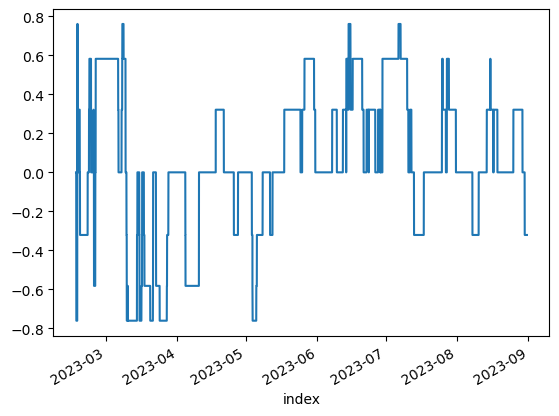

In [198]:
pos[0].plot()

<AxesSubplot:xlabel='index'>

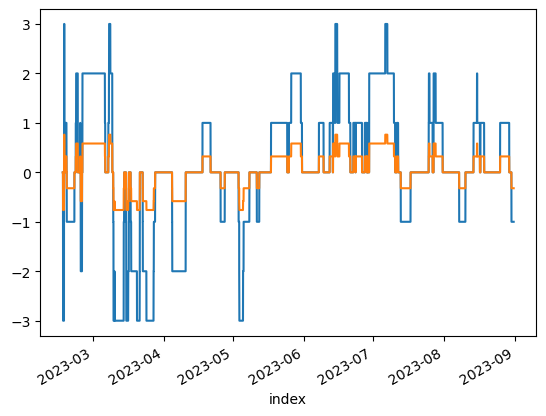

In [199]:
df_master_positions[0].plot()
pos[0].plot()


<AxesSubplot:xlabel='index'>

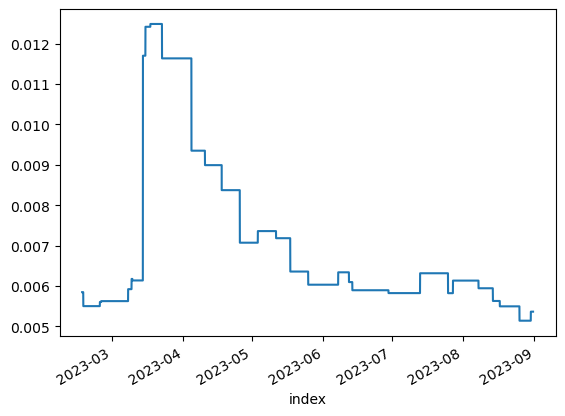

In [160]:
pos1['vol_start_pos'].plot()

In [149]:
pos1#[['vol','vol_start_pos']].plot()

,close,indicator,positions,trade_grouping_diff,vol,vol_start_pos
index,,,,,,
2023-02-15 19:06:00,96.350,0.706871,0.0,0.0,NaN,NaN
2023-02-15 19:38:00,96.355,0.999556,0.0,0.0,NaN,NaN
2023-02-15 19:57:00,96.355,0.782859,0.0,0.0,0.003536,NaN
2023-02-15 20:18:00,96.355,0.670285,0.0,0.0,0.002886,NaN
2023-02-15 20:29:00,96.360,1.290269,0.0,0.0,0.002887,NaN
...,...,...,...,...,...,...
2023-08-31 09:00:00,95.800,0.628460,0.0,-0.0,0.005239,0.005366
2023-08-31 09:01:00,95.800,0.628168,0.0,-0.0,0.005237,0.005366
2023-08-31 09:04:00,95.795,0.571540,0.0,-0.0,0.005237,0.005366


In [112]:
pos1[['indicator','positions','trade_grouping_diff']][pos1.index.date==datetime.date(2023, 2, 15)].plot()

ValueError: Item wrong length 44997 instead of 60.

<AxesSubplot:xlabel='index'>

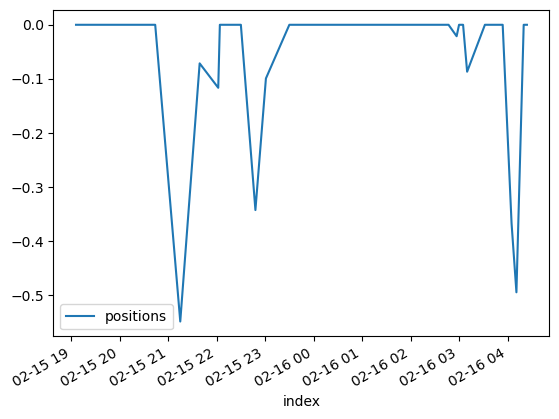

In [155]:
pos1[['positions']].iloc[0:40].plot()

In [38]:

df_master_positions['combined_pos'] = df_master_positions['slow']+df_master_positions['medium']+df_master_positions['fast']
df_master_positions['']

In [197]:
df_results['lookback'] = results_lookback_list
#df_results['indicator_lag'] = np.tile(lag_list, len(df_results) // len(lag_list) + 1)[:len(df_results)]  
df_results['holdtime_mins'] = results_hold_list
df_results['trigger_bound'] = results_bound_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['long_avg_ticks'] = long_time_list
df_results['short_avg_ticks'] = short_time_list
df_results['long_avg_abs_pnl'] = long_avg_return_list
df_results['short_avg_abs_pnl'] = short_avg_return_list
df_results['long_hitrate'] = long_hitrate_list
df_results['short_hitrate'] = short_hitrate_list
df_results['mean_return_bps'] = mean_return_list
df_results['hitrate'] = hitrate_list
df_results['hitrate_after_bro']  = hitrate_bro_list

#average time in trade

df_results#.to_csv('backtest_detrend_meanreversion_intra_sfrz4_run3.csv')


,lookback,holdtime_mins,trigger_bound,apr,sharpe,max_dd,max_dd_ticks,max_dd_days,long_trades_no,short_trades_no,long_avg_ticks,short_avg_ticks,long_avg_abs_pnl,short_avg_abs_pnl,long_hitrate,short_hitrate,mean_return_bps,hitrate,hitrate_after_bro
0,1500,540,1.5,0.012243,1.431092,-0.005077,6597.0,4.58125,15,16,826.0,-563.0,0.015667,0.073437,0.6,0.875,0.045484,0.741935,0.677419


In [55]:
df_results

,lookback,holdtime_mins,trigger_bound,apr,sharpe,max_dd,max_dd_ticks,max_dd_days,long_trades_no,short_trades_no,long_avg_ticks,short_avg_ticks,long_avg_abs_pnl,short_avg_abs_pnl,long_hitrate,short_hitrate,mean_return_bps,hitrate,hitrate_after_bro
0,3600,360,1.9,0.020449,2.001236,-0.006676,13996.0,9.719444,7,6,518.0,-653.0,0.075714,0.152500,0.857143,0.666667,0.111154,0.769231,0.769231
1,1800,540,1.8,0.020562,1.864329,-0.006676,13725.0,9.531250,10,9,680.0,-540.0,0.028500,0.130000,0.600000,0.777778,0.076579,0.684211,0.684211
2,1500,540,1.5,0.019922,1.433596,-0.007315,19121.0,13.278472,15,16,826.0,-563.0,0.015667,0.073437,0.600000,0.875000,0.045484,0.741935,0.677419
